# Training Model MERA
<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Experiment 1](#3)
    a. [Training](#4)
    b. [Test Accuracy](#5)
4. [Experiment 2](#6)
    a. [Training](#7)
    b. [Test Accuracy](#8)
4. [Experiment 3](#9)
    a. [Training](#10)
    b. [Test Accuracy](#11)
5. [Experiment 4](#12)
    a. [Training](#13)
    b. [Test Accuracy](#14)

Data Preparation:
* image_limit: `500`
* cropping parameters: `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`
* image size to resize: `(64, 64)`
* pca component: `256`
* split data to train and validation - `train_ratio=0.7`

Without batches:
Mera_350_images:
* Training set: [345 343 365 352 350 344]
* Validation set: [54 52 42 48 56 49]
* Test set: [101 105  93 100  94 107]
* Cost function: Cross-Entropy Loss
* Epoch: 20
* learning rate: 0.1
* Accuracy validation test: max 46.52%
* training time: about 4 h



| Experiment | Training set         | Validation set       | Test set             | Cost function      | Epoch | Batch | Learning rate | Training time | Val_accuracy | Test_accuracy |
|------------|-----------------------|----------------------|----------------------|--------------------|-------|-------|----------------|---------------|--------------|---------------|
| 1          | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 70    | 64    | 0.05           | 0.5 h         | 56.81%       | 47.16%        |
| 2          | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 100   | 128   | 0.01           | 1 h           | 46.18%       | 42.5%          |
| 3          | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 215   | 32    | 0.01           | 1.5 h         | 48.18%       | 42.66%        |
| 4          | [692 688 710 702 716 691] | [93 113 107 100 87 101] | [215 199 183 198 197 208] | Cross-Entropy Loss | 300   | 64    | 0.05           | 7.5 h         | 59,9%          | 57%           |


<a id="1"></a>
### Data Preparation

In [1]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(
    json_paths=['C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/train/train.json', 'C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/test/test.json'],
    data_dirs=['C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/train', 'C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/test'],
    image_size=(64, 64)
)

In [2]:
all_data = loader.load_images(image_limit=5000,vertical_start_split=0.35, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 23800, Current label: 5, Total per label: {0: 5000, 1: 2134, 2: 5000, 3: 5000, 4: 3682, 5: 2984}

Total images loaded : 23869


In [3]:
org = all_data[:]

In [9]:
from Modules.Utils import reduce_dataset_to_2_classes
new_all_data = reduce_dataset_to_2_classes(all_data, class_0_count=5000, other_classes_count=1000)

Shuffles the dataset and separates it into flattened features and labels.

In [10]:
import Modules.Utils
X_set,Y_set = Modules.Utils.prepare_data(new_all_data)

In [11]:
import numpy as np
for i in range(len(X_set)):
    X_set[i] = np.reshape(X_set[i], (64, 64, 1))

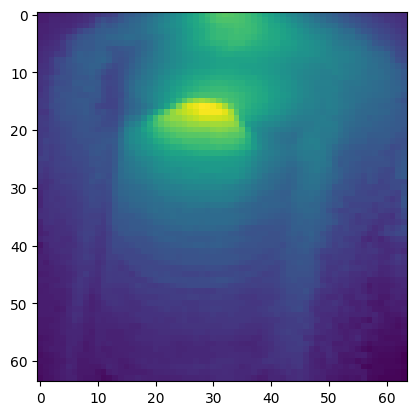

In [17]:
import matplotlib.pyplot as plt
plt.imshow(X_set[6000])

In [18]:
#X_reduced = Modules.Utils.apply_pca(X_set, n_components=256)

Split train data into train set, validation set and test set.

In [19]:
from Modules.Utils import split_data_into_train_val_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X_set, Y_set, train_ratio=0.8, val_ratio=0.1,test_ratio=0.1)

Y_train: Values: [0 1] Counts: [4009 3990]
Y_val: Values: [0 1] Counts: [490 511]
Y_test: Values: [0 1] Counts: [501 499]


In [20]:
X_train = np.array(X_train).astype('float32') / 255.
X_test = np.array(X_test).astype('float32') / 255.
X_val = np.array(X_val).astype('float32') / 255.

In [25]:
import keras
from keras import layers, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import ops
import tensorflow as tf

In [22]:
X_train[0].shape

(64, 64, 1)

In [596]:
from keras.layers import Input, Reshape, UpSampling2D

input_img = Input(shape=(64, 64, 1))

encoded = keras.layers.Conv2D(8, (2, 2), strides = 2, activation='relu', padding='same')(input_img)
encoded1 = keras.layers.MaxPool2D(pool_size=(2, 2), name='pool1')(encoded)
encoded2 = keras.layers.Conv2D(16, (2, 2), strides = 2, activation='relu', padding='same')(encoded1)
encoded3 = keras.layers.MaxPool2D(pool_size=(2, 2), name='pool2')(encoded2)
encoded4 = keras.layers.Conv2D(16, (2, 2), strides = 1, activation='relu', padding='same')(encoded3)

encoded5 = keras.layers.Flatten(name='block1_flat1')(encoded4)

decoded = Reshape((4, 4, 16))(encoded5)
decoded1 = UpSampling2D((2, 2))(decoded)
decoded2 = keras.layers.Conv2D(16, (3, 3), strides = 1, activation='relu', padding='same')(decoded1)
decoded3 = UpSampling2D((2, 2))(decoded2)
decoded4 = UpSampling2D((2, 2))(decoded3)
decoded5 = UpSampling2D((2, 2))(decoded4)
decoded6 = keras.layers.Conv2D(1, (3, 3), strides = 1, activation='sigmoid', padding='same')(decoded5)

In [597]:
print(encoded.shape)
print(encoded1.shape)
print(encoded2.shape)
print(encoded3.shape)
print(encoded4.shape)
print(encoded5.shape)
print(decoded.shape)
print(decoded1.shape)
print(decoded2.shape)
print(decoded3.shape)
print(decoded4.shape)
print(decoded5.shape)
print(decoded6.shape)

(None, 32, 32, 8)
(None, 16, 16, 8)
(None, 8, 8, 16)
(None, 4, 4, 16)
(None, 4, 4, 16)
(None, 256)
(None, 4, 4, 16)
(None, 8, 8, 16)
(None, 8, 8, 16)
(None, 16, 16, 16)
(None, 32, 32, 16)
(None, 64, 64, 16)
(None, 64, 64, 1)


In [598]:
X_train[0].shape

(64, 64, 1)

In [599]:
model = Model(input_img, decoded6)
model.compile(optimizer='adam', loss='mean_squared_error')

In [600]:
model.summary()

Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_90 (InputLayer)          │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_450 (Conv2D)                  │ (None, 32, 32, 8)           │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_451 (Conv2D)                  │ (None, 8, 8, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_452 (Conv2D)                  │ (None, 4, 4, 16)            │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_flat1 (Flatten)               │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_54 (Reshape)                 │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_213 (UpSampling2D)     │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_453 (Conv2D)                  │ (None, 8, 8, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_214 (UpSampling2D)     │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_215 (UpSampling2D)     │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_216 (UpSampling2D)     │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_454 (Conv2D)                  │ (None, 64, 64, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,073 (15.91 KB)

 Trainable params: 4,073 (15.91 KB)

 Non-trainable params: 0 (0.00 B)

In [601]:
model.fit(np.array(X_train), np.array(X_train),
                epochs=50,
                batch_size=8,
                shuffle=True, validation_data=(np.array(X_test), np.array(X_test)))

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0116 - val_loss: 0.0027
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/ste

In [602]:
encoder = keras.Model(input_img, encoded5)

In [603]:
encoded_X_train = encoder.predict(X_train)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [604]:
encoded_X_test = encoder.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [605]:
encoded_X_val = encoder.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [29]:
from keras.layers import Input, Reshape, UpSampling2D
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation="relu")(x)
encoder = layers.Dense(256, activation="relu")(x)

x = layers.Dense(8* 8 * 64, activation="relu")(encoder)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [30]:
model = Model(encoder_inputs, decoder)
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │      16,385,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         256,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 64, 64, 1)           │             145 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,772,905 (67.80 MB)

 Trainable params: 17,772,905 (67.80 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.fit(np.array(X_train), np.array(X_train),
                epochs=5,
                batch_size=8,
                shuffle=True, validation_data=(np.array(X_test), np.array(X_test)))

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 152s 152ms/step - loss: 3.0886e-04 - val_loss: 3.3969e-04
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 152s 152ms/step - loss: 3.0453e-04 - val_loss: 3.3520e-04
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 202s 152ms/step - loss: 3.0247e-04 - val_loss: 3.2229e-04
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 153s 153ms/step - loss: 2.9261e-04 - val_loss: 3.2533e-04
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 152s 152ms/step - loss: 2.9245e-04 - val_loss: 3.3883e-04


In [35]:
encod = keras.Model(encoder_inputs, encoder)

In [36]:
encoded_X_train = encod.predict(X_train)

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [37]:
encoded_X_val = encod.predict(X_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [38]:
encoded_X_test = encod.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


<a id="2"></a>
### Model

Block from article looks like:
![circuit](./Images/MERA_block_1.png)

First three gate RZ,RY,RZ can be change into qml.Rot().

(<Figure size 1000x300 with 1 Axes>, <Axes: >)

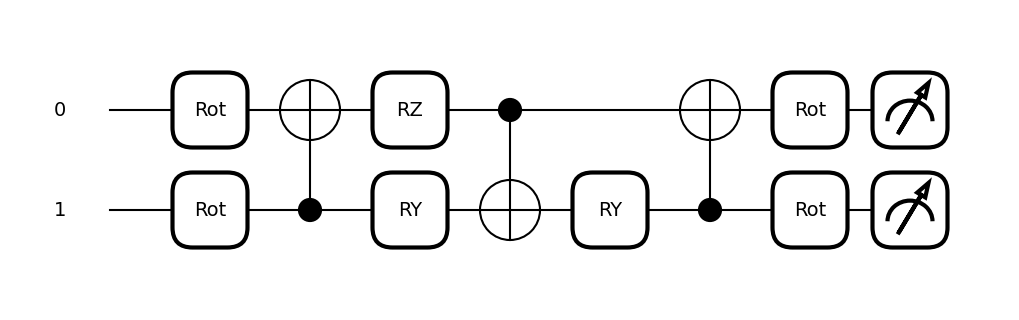

In [39]:
import pennylane as qml
from pennylane import numpy as np
def block(weights, wires):
    qml.Rot(weights[0],weights[1],weights[2],wires=wires[0])
    qml.Rot(weights[3],weights[4],weights[5],wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(weights[6], wires=wires[0])

    qml.RY(weights[7], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(weights[8], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])
    qml.Rot(weights[9],weights[10],weights[11],wires=wires[0])
    qml.Rot(weights[12],weights[13],weights[14],wires=wires[1])

dev= qml.device('default.qubit',wires=range(2))
@qml.qnode(dev)
def circuit_block(f, template_weights):
    block(template_weights,wires=[0,1])
    return qml.probs(wires = [0, 1])

weights = np.random.random(size=[15, 1])
qml.draw_mpl(circuit_block, expansion_strategy="device")(encoded_X_train[0][0:4], weights)

MERA architecture looks like:

![Mera circuit](./Images/MERA_1.png)

In [689]:
encoded_X_train2 = []
encoded_X_test2 = []
encoded_X_val2 = []

for i in range(len(encoded_X_train)):
    encoded_X_train2.append(encoded_X_train[i]/max(encoded_X_train[i]))
    for j in range(len(encoded_X_train2[i])):
        if encoded_X_train2[i][j] >= 0.5:
            encoded_X_train2[i][j] = 1
        else:
            encoded_X_train2[i][j] = 0

for i in range(len(encoded_X_test)):
    encoded_X_test2.append(encoded_X_test[i]/max(encoded_X_test[i]))
    for j in range(len(encoded_X_test2[i])):
        if encoded_X_test2[i][j] >= 0.5:
            encoded_X_test2[i][j] = 1
        else:
            encoded_X_test2[i][j] = 0

for i in range(len(encoded_X_val)):
    encoded_X_val2.append(encoded_X_val[i]/max(encoded_X_val[i]))
    for j in range(len(encoded_X_val2[i])):
        if encoded_X_val2[i][j] >= 0.5:
            encoded_X_val2[i][j] = 1
        else:
            encoded_X_val2[i][j] = 0

In [700]:
encoded_X_train2 = np.array(encoded_X_train2)
encoded_X_test2 = np.array(encoded_X_test2)
encoded_X_val2 = np.array(encoded_X_val2)

(<Figure size 6800x900 with 1 Axes>, <Axes: >)

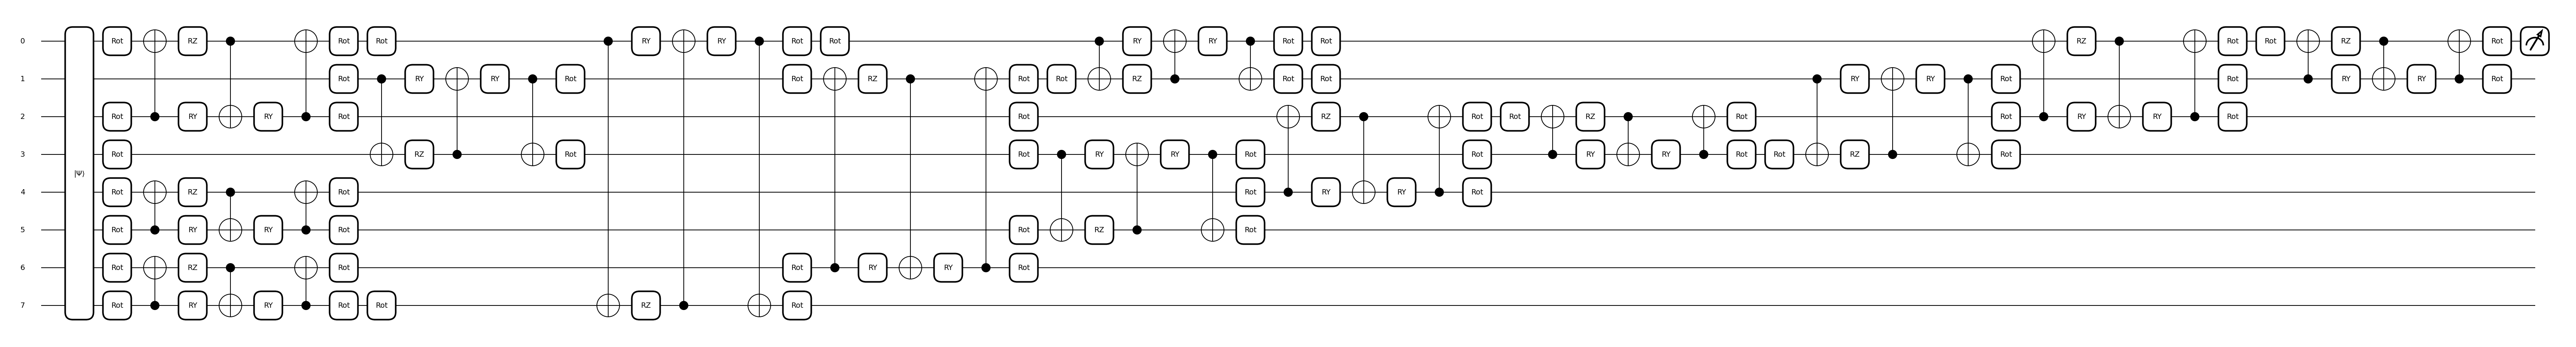

In [40]:
n_wires = 8
n_block_wires = 2
n_params_block = 15
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)
template_weights = [[0.1,-0.3]]*n_blocks


dev= qml.device('default.qubit',wires=range(n_wires))
@qml.qnode(dev)
def circuit_MERA(f, template_weights):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True)
    qml.MERA(range(n_wires),n_block_wires,block, n_params_block, template_weights)
    return qml.probs(wires = [0])


weights = np.random.random(size=[13, 15])
qml.draw_mpl(circuit_MERA, expansion_strategy="device")(encoded_X_train[0], weights)

<a id="3"></a>
### Experiments 1
<a id="4"></a>
#### Training
* Training set: [349 364 350 350 325 361]
* Validation set: [61 42 39 51 61 47]
* Test set: [ 90  94 111  99 114  92]
* Cost function: Cross-Entropy Loss
* Epoch: 70
* batch: 64
* learning rate:0.05
* val_accuracy: 56,81%

In [41]:
import math
from pennylane import numpy as np
from Modules.training import costfunc_exponential

training the circuit parameters

In [42]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.03)
batch_size = 128
all_params = []
all_cost = []
all_accuracy = []

In [43]:
from Modules.metrices import accuracy
from Modules.training import costfunc_focal, costfunc_cross_entropy

for k in range(200):
    batch_index = np.random.randint(0, len(encoded_X_train), (batch_size,))
    X_batch = encoded_X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params, cost = optimizer.step_and_cost(costfunc_exponential, params, X=X_batch, Y=Y_batch, circuit=circuit_MERA, num_classes=2)
    accuracy_value = accuracy(params,encoded_X_val,Y_val,circuit_MERA)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0| Cost: 0.3875437097130675 | Validation accuracy: 57.04%
Step 1| Cost: 0.36992978945068533 | Validation accuracy: 58.34%
Step 2| Cost: 0.374091901236194 | Validation accuracy: 69.23%
Step 3| Cost: 0.3460934950990541 | Validation accuracy: 67.93%
Step 4| Cost: 0.340749742080505 | Validation accuracy: 63.34%
Step 5| Cost: 0.3659586012782374 | Validation accuracy: 68.83%
Step 6| Cost: 0.3592173076116104 | Validation accuracy: 76.42%
Step 7| Cost: 0.33636374965711185 | Validation accuracy: 71.83%
Step 8| Cost: 0.33166339900740194 | Validation accuracy: 65.83%
Step 9| Cost: 0.3448314522237743 | Validation accuracy: 64.84%
Step 10| Cost: 0.3411464413162044 | Validation accuracy: 67.63%
Step 11| Cost: 0.3523093711079728 | Validation accuracy: 76.12%
Step 12| Cost: 0.3263300488921125 | Validation accuracy: 79.42%
Step 13| Cost: 0.30823114124787354 | Validation accuracy: 75.82%
Step 14| Cost: 0.318203296918263 | Validation accuracy: 72.93%
Step 15| Cost: 0.30430943639623353 | Validation a

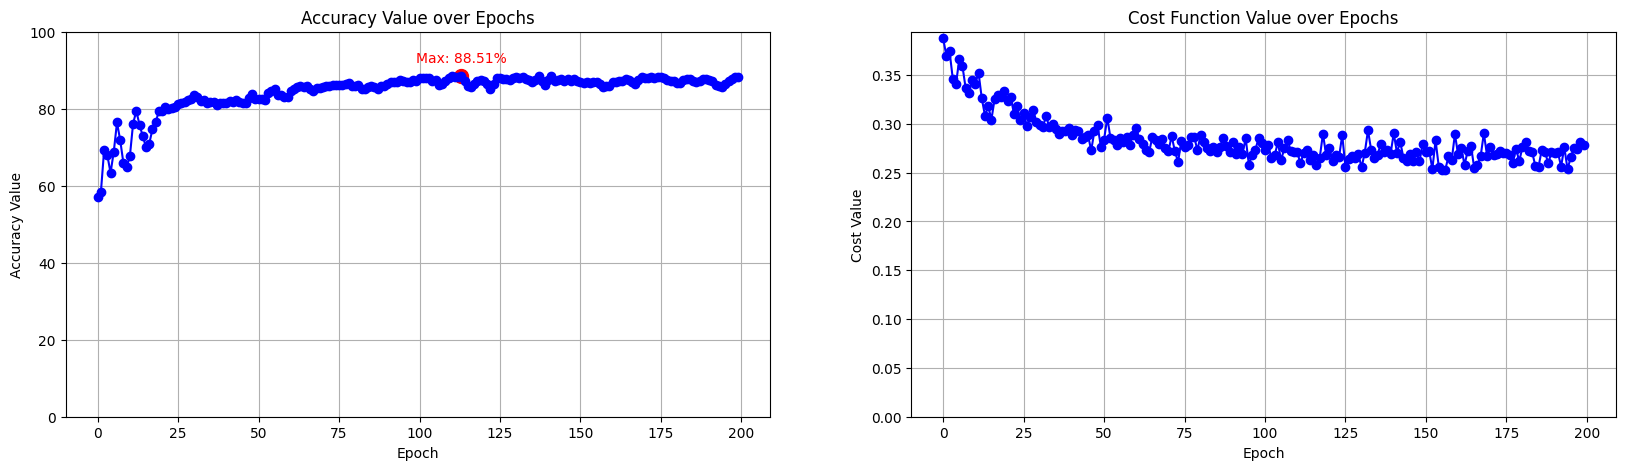

In [44]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

<a id="5"></a>
### Accuracy
* test_accuracy: 47,16%

In [45]:
test_accuracy = accuracy(params,encoded_X_test,Y_test,circuit_MERA)

In [46]:
test_accuracy

89.8